# K-means Algorithm with Images

**Name**: ZHU GUANGYU  
**Student ID**: 20165953  
**Github Repo**: [assignment04](https://github.com/z1ggy-o/cv_assignment/tree/master/assignment04)  

---

## Clustering

the goal of *clustering* is to group or partition the vectors into *k* groups or clusters, with the vectors in each group close to each other.

the best clustering:
- can find the best slustering, if the representatives are fixed;
- can find the vest representatives, if the clustering is fixed.

We use a single number to judge a choice of clustering, along with a choice of the group. We define:

$$
J^{clust}=(||x_{1}-z_{c_{1}}||^{2}+ \cdots +||x_{N}-z_{c_{N}}||^{2})/N
$$

Here $x_{N}$ is vector, $z_{c_{N}}$ is correspond representatives. We call this value *energy* or *cost*.

### When representatives fixed

We assign each date vector $x_{i}$ to its nearest representatives. Since the representatives are fixed, we actually re-grouped vectors into different partitions. We have:
$$ ||x_{i}-z_{c_{i}}|| = \min_{j=1,\cdots\,k}||x_{i}-z_{c_{i}}|| $$ 

This gives us the minimum $J^{clust}$.

### When group assignment fixed

This means the element vectors of each group are fixed. We need to find the group representatives to minimize our cost $J^{clust}$.

Simply, choose the average of the vectros in its group:
$$ z_{j} = (1/|G_{j}|)\sum_{i\in G_{j}}x_{i}$$

since this makes the sum of distance between points and its representative minimum.

## *k*-means Algorithm

Previous two methods can help us get the best clustering. But the two methods are depend on each other. To solve this problem, we can use *k-means algorithm*.

*k-means algorithm*'s idea is simple. We repeatedly alternate between updating the group assignments, then updating the representatives. In each iteration we get a better $J^{clust}$ until the step does not change the choice.

Have to be aware of is k-means algorithm **cannot** guarantee that the partition it finds minimizes $J^{clust}$. Commonly, we run it several times with different initial representatives, and choose the one with the smallest cost.

There is another problem is to determin the optimal number of clusters (here is the *k*).  
If you have given number of clusters, that's fine. If you don't, there are few methods can help us:

- [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_%28clustering%29 )
- [The silhouette method](https://en.wikipedia.org/wiki/Silhouette_%28clustering%29)
- [Gap statistic](http://web.stanford.edu/~hastie/Papers/gap.pdf)

---


## Implementation

This time we try to modify the *k-means* algorithm we did last time to cluster image datas.

The algorithm part is almost same, just need to change the data vector size and plotting functions.

---

First, import packages that we need.

- `numpy` for scientific computing
- `matplotlib` for visualization
- `math` is the python build in math packages.

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

### Read file and pre-processing

Define a class called `DataSet` to read image data from file and normaize the input data.

In [2]:
class DataSet:
    """Read data from files

    Read image datas from data files.
    Normalize the data then change the data to vector from
    """

    def __init__(self, file="mnist_test.csv"):
        self.size_row = 28  # height of the image data
        self.size_col = 28  # width of the image data
        self.len_vec = self.size_row * self.size_col

        # read data from file
        _handle_file = open(file, 'r')
        _data = _handle_file.readlines()
        _handle_file.close()

        self.num_image = len(_data)

        self.list_image = np.empty((self.len_vec, self.num_image), dtype=float)
        self.list_label = np.empty(self.num_image, dtype=int)

        # change the image datas into vector forms
        _count = 0
        for line in _data:
            line_data = line.split(',')
            label = line_data[0]
            img_vector = np.asfarray(line_data[1:])
            img_vector = self._normalize(img_vector)

            self.list_label[_count] = label
            self.list_image[:, _count] = img_vector  # [:, i] get ith col
            _count += 1

*normalizing* means transforming the vector so that it has unit norm.

Here we do the normalizing by formula:
$$z_{i} = \frac{x_{i}-\min{(x)}}{\max{(x)}-\min{(x)}}$$

In [4]:
    def _normalize(self, data):
        """Normalize the values of the input data into [0, 1]"""
        data_normalized = (data - min(data)) / (max(data) - min(data))

        return data_normalized
    
# for jupyter notebook
DataSet._normalize = _normalize

---

### k-means algorithm part

Create a class `KMeans` to group the functions about algorithm together.

Here the `__init__` constructor has two parameters:

- `data`: image data read by `DataSet`
- `k`: number of clusters we want

In [5]:
class KMeans:
    """k-means algorithm for images

    Clustring the image datas into k groups.
    Compute each iteration's energy and accuracy. 
    """

    def __init__(self, data, k=10):
        self.k = k
        self.data = data
        self.energy_history = []
        self.accuracy_history = []
        self.centroids = []
        self.clusters = [[] for _ in range(k)]
        self.labels = []

#### Define some getter function for plotting graph.

In [6]:
    def getEnergyHistory(self):
        return self.energy_history

    def getAccuracyHistory(self):
        return self.accuracy_history
    
# for jupyter notebook
KMeans.getEnergyHistory = getEnergyHistory
KMeans.getAccuracyHistory = getAccuracyHistory

#### Define the initialization function

This initialization function will:

1. randomly assign labels to images
2. compute the initial centroids
3. compute the initial system energy
4. compute the initial accuracy

We separate each step into different functions.

In [7]:
    def initialCluster(self):
        self._initialLabel()
        self._computeCentroid()
        self._computeEnergy()
        self._computeAccuracy()
        
# for jupyter notebook
KMeans.initialCluster = initialCluster

Label initialization is very simple.  
In range $[0,k)$, we assign labels to images in order.

Instead of store the data vector into cluster list, we just append
image's index in `list_image`.  
Use index can let easily get each image's original label.

In [8]:
    def _initialLabel(self):
        # for i in range(100):
        for i in range(self.data.num_image):
            index = i % self.k
            self.clusters[index].append(i)
            
# for jupyter notebook
KMeans._initialLabel = _initialLabel

We still use vectors' mean value as cluster's centroid.

The compute method is same, but the data structure have been changed.
Here we use nest array to represent a data matrix. Each column of the matrix is one image's data.

I used the simplest way, traversal the matrix, to access data. It works, but the time complexity becomes to $row \cdot col$

In [9]:
   def _computeCentroid(self):
        """ Compute each groups centroid then update self.controids """

        new_centroids = []
        n = self.data.len_vec

        for cluster in self.clusters:
            centroid = [0] * n
            num_elements = 0

            # sum of the cluster's elements
            for img in cluster:
                num_elements += 1
                for row in range(n):
                    centroid[row] += self.data.list_image[row][img]

            centroid = [row/num_elements for row in centroid]
            new_centroids.append(centroid)

        self.centroids = new_centroids
        
# for jupyter notebook
KMeans._computeCentroid = _computeCentroid

The **energy** computation is same as before:
$$
J^{clust}=(||x_{1}-z_{c_{1}}||^{2}+ \cdots +||x_{N}-z_{c_{N}}||^{2})/N
$$

Because of the data representation, we use `list_image[:, index]` this
syntex to get the column of the matrix.

In [11]:
def _computeEnergy(self):
        """ Compute the cost of the clustering result

        Return:
            energy(float): the energy of this clustering.
        """

        energy = 0
        for i in range(len(self.centroids)):
            centroid = self.centroids[i]
            part_energy = 0
            for index in self.clusters[i]:
                part_energy += self._computeDistance(
                    x=self.data.list_image[:, index], y=centroid)
            energy += part_energy
        energy = energy / self.data.num_image
        self.energy_history.append(energy)

        return energy
    
# for jupyter notebook
KMeans._computeEnergy = _computeEnergy

The **accuracy** is the ratio of the most frequently occurring elements in the group.  
So we need to iterate all the elements then find the most frequently occurring image and count the number of occurrences.

In [12]:
def _computeAccuracy(self):
        """Compute the arrcuracy of the result

        In each group, let the largest number of elements to be the group label.
        """

        accuracy = 0
        labels_clusters = []

        for cluster in self.clusters:
            labels = []

            # get all the labels in the cluster
            for index in cluster:
                labels.append(self.data.list_label[index])

            # get the largest number of lable, count the occurences
            labels.sort()
            count = 0
            count_max = 0
            label_prev = -1
            label_max = -1
            for label in labels:
                if label == label_prev:
                    count += 1
                else:
                    if count > count_max:
                        count_max = count
                        label_max = label_prev
                    label_prev = label
                    count = 1
            # check the last item
            if count > count_max:
                count_max = count
                label_max = label_prev

            labels_clusters.append(label_max)
            accuracy_part = count_max / len(cluster)
            accuracy += accuracy_part

        accuracy = accuracy / len(self.clusters)
        self.labels = labels_clusters
        self.accuracy_history.append(accuracy)
        
# for jupyter notebook
KMeans._computeAccuracy = _computeAccuracy

---

### Trigger funtions

In trigger function `run`, we define the condition to control when to stop our algorithm.

Here we let the algorithm keep running until the `energy` not change.  
Also computhe *energy* and *accuracy* of each iteration.

In [13]:
    def run(self):
        """Run algorithm

        Repeatly assign labels to points and compute new centroids.
        Iterate until the energy of the result not change.
        """

        energy_prev = 0
        energy_this = self.energy_history[0]
        while(energy_this != energy_prev):
            energy_prev = energy_this
            energy_this = self._clustering()
            self._computeAccuracy()
            
# for jupyter notebook
KMeans.run = run

Inside the `_clustering` function, it call `_assignLabel` and `_computeCentroid` one time to generate new result.

Here we add one step after `_assignLabel` to remove the empty clusters.

In [15]:
    def _clustering(self):
        """Run algorithm one iteration

        Return:
            energy: This iteration's result energy
        """

        self._assignLabel()
        # After re-grouping if there are any empty cluster, delete it from list
        self.clusters = [list for list in self.clusters if list]
        self._computeCentroid()

        return self._computeEnergy()
    
# for jupyter notebook
KMeans._clustering = _clustering

Assign new label to images depends on the Euclidean distance between each image vector and its centroid vector.

In [16]:
    def _assignLabel(self):
        """ Assign labels to elemetns for generating new groups

        Compute distance between each element with each centroid,
        assign it to the closest centroid's group.
        """

        # for each element, compute the distance, get the closest centroid
        # generate k new cluster
        new_clusters = [[] for _ in range(len(self.clusters))]

        for index in range(self.data.num_image):
            min = math.inf
            closest = 0
            # find the closest centroid
            for j in range(len(self.centroids)):
                dist = self._computeDistance(
                    x=self.data.list_image[:, index], y=self.centroids[j])
                if dist < min:
                    min = dist
                    closest = j
            # put point into new group
            new_clusters[closest].append(index)

        self.clusters = new_clusters
        
# for jupyter notebook
KMeans._assignLabel = _assignLabel

*Euclidean distance* function.  
Since we just use this value to do the comparison, we do not need the
square root value.

In [17]:
    def _computeDistance(self, x, y):
        """Compute the distance between two points

        (x1-x2)^2 + (y1-y2)^2
        """

        # convert python list to np.array
        x = np.array(x)
        y = np.array(y)

        d = (x - y)**2
        s = np.sum(d)

        return s
    
# for jupyter notebook
KMeans._computeDistance = _computeDistance

### Plotting functions

We define two plotting functions here.

- `plotImages`: plot the clustering result images
- `plotChanges`: plot each iteration's energy and accuracy variations

In [61]:
def plotImages(kmeans):
    """Plot the graph of clusters average value"""
    k = len(kmeans.clusters)
    size = kmeans.data.len_vec

    im_average = np.zeros((size, k), dtype=float)
    im_count = np.zeros(k, dtype=int)

    # add each cluster's image value together
    for i in range(k):
        for img in kmeans.clusters[i]:
            im_average[:, i] += kmeans.data.list_image[:, img]

    # count number of each cluster's elements
    for i in range(k):
        im_count[i] = len(kmeans.clusters[i])

    for i in range(k):
        im_average[:, i] /= im_count[i]

        plt.subplot(2, 5, i+1)
        plt.title(kmeans.labels[i])
        plt.imshow(im_average[:, i].reshape(
                                            (kmeans.data.size_row,
                                             kmeans.data.size_col)),
                   cmap='Greys', interpolation='None')

        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

    plt.show()
    

def plotChanges(energies, accuracis):
    """Plot energy & accuracy history

    Parameter:
        energies(list): a list of energy
        accuracis(list): a list of accuracy
    """

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig = plt.figure()
    
    
    ite = [i for i in np.arange(1, len(energies)+1, 1)]
    
    ax1 = fig.add_subplot(111)
    ax1.set_title('Energy and Accuracy Variasion')
    ax1.set_ylabel(r'Energy $J^{clust}$')
    ax1.set_xticks(np.arange(1, len(energies)+1, step=5))
    ax1.plot(ite, energies, '.-', color='b', label='Energy')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuray')
    ax2.get_xaxis().set_visible(False)
    ax2.plot(ite, accuracis, '.-', color='r', label='Accuracy')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.)
    
    plt.show()
    

## Result

Now let run the program to check the result.

### K=10
First, let's try when `k=10`:

#### 1. Initial Images:

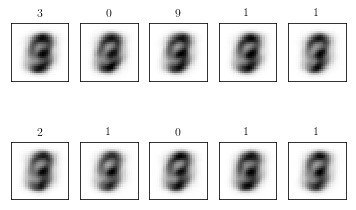

In [21]:
if __name__ == '__main__':
    data = DataSet()
    kmeans = KMeans(data, 10)
    kmeans.initialCluster()
    plotImages(kmeans)

    kmeans.run()
    

#### 2. Final Images

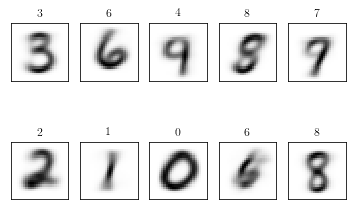

In [22]:
plotImages(kmeans)

#### 3. Energy and Accuray changes

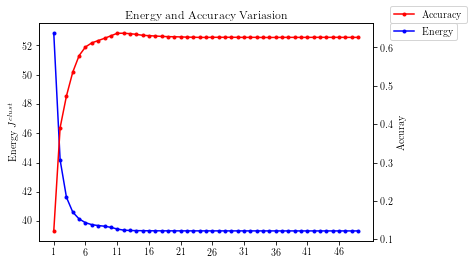

Accuracy: 0.63


In [86]:
plotChanges(kmeans.getEnergyHistory(), kmeans.getAccuracyHistory())

print('Accuracy: {0:.2f}'.format(kmeans.getAccuracyHistory()[-1]))

### Other *k* values

Let try other k to check how accuracy changes.

#### k = 5

In [64]:
    kmeans_5 = KMeans(data, 5)
    kmeans_5.initialCluster()
    kmeans_5.run()

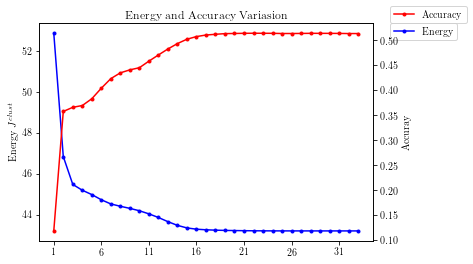

In [66]:
plotChanges(kmeans_5.getEnergyHistory(), kmeans_5.getAccuracyHistory())

#### k = 20

In [67]:
    kmeans_20 = KMeans(data, 20)
    kmeans_20.initialCluster()
    kmeans_20.run()

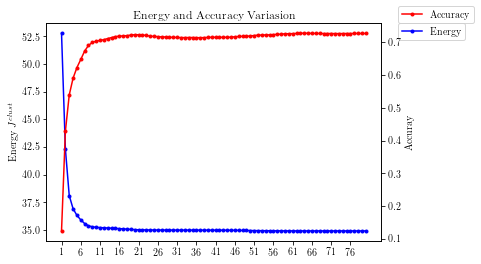

In [68]:
plotChanges(kmeans_20.getEnergyHistory(), kmeans_20.getAccuracyHistory())

#### k = 50

In [69]:
    kmeans_50 = KMeans(data, 50)
    kmeans_50.initialCluster()
    kmeans_50.run()

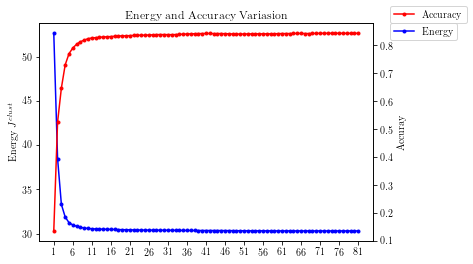

In [71]:
plotChanges(kmeans_50.getEnergyHistory(), kmeans_50.getAccuracyHistory())

#### K = 100

In [72]:
    kmeans_100 = KMeans(data, 100)
    kmeans_100.initialCluster()
    kmeans_100.run()

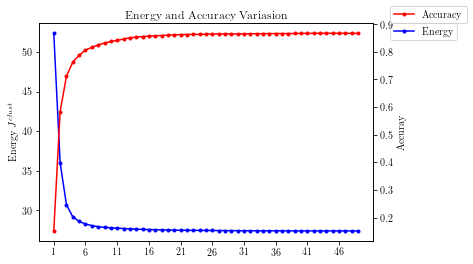

In [74]:
plotChanges(kmeans_100.getEnergyHistory(), kmeans_100.getAccuracyHistory())

#### Compare

We can see from the graph, along with the *k* increase, the accuracy increase too.

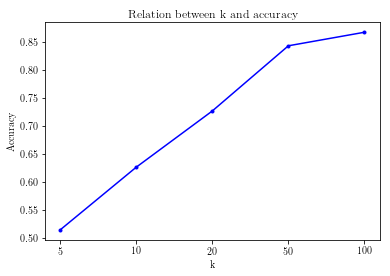

In [83]:
acc = []
acc.append(kmeans_5.getAccuracyHistory()[-1])
acc.append(kmeans.getAccuracyHistory()[-1])
acc.append(kmeans_20.getAccuracyHistory()[-1])
acc.append(kmeans_50.getAccuracyHistory()[-1])
acc.append(kmeans_100.getAccuracyHistory()[-1])

fig = plt.figure(2)
    
ite = [i for i in np.arange(1, 6, 1)]
index_ls = ['5', '10', '20', '50', '100']
plt.title('Relation between k and accuracy')
plt.xticks(ite, index_ls)
plt.ylabel('Accuracy')
plt.xlabel('k')
plt.plot(ite, acc, '.-', color='b')

plt.show()